In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator

#import rewarder class
from rewarders.linearRewarder import LinearRewarder
from rewarders.thresholdRewarder import ThresholdRewarder

from utils.sequences_treatment import *

# import environment class
from optimalIntermittency import OptimalIntermittency

# import deer classes
from deer.learning_algos.q_net_keras import MyQNetwork
from deer.agent import NeuralAgent
import deer.experiment.base_controllers as bc

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 240 samples, validate on 60 samples
Epoch 1/1
 - 22s - loss: 0.1100 - val_loss: 0.0884


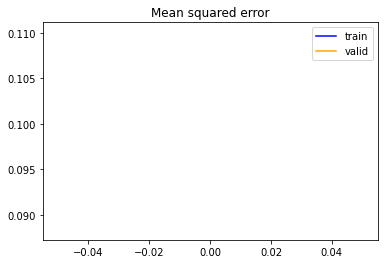

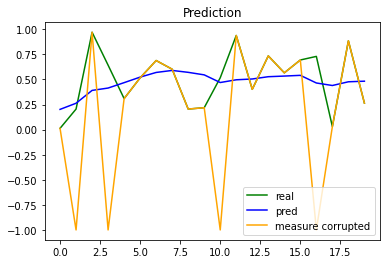

In [3]:
# construct and train a Sequential RNN model with keras
numberSamples=300
T_train=20
generatorType='random01'

# generate sequences for training
(obj_train,obs_train)=generateSequence(T_train,numberSamples=numberSamples,generatorType=generatorType)
sigma=randomSigma(T_train,numberSamples=numberSamples,p0=0.2)
obs_train_corrupted=corruptSequence_outOfRange(obs_train,sigma)

n_dim_obs=np.shape(obs_train_corrupted)[2]
n_dim_obj=np.shape(obj_train)[2]

model=Sequential()
model.add(LSTM(20,input_shape=(None,n_dim_obs),return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(Dense(n_dim_obj,activation=None))

model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

# train the RNN
history=model.fit(x=obs_train_corrupted,y=obj_train,batch_size=1,epochs=1,validation_split=0.2,verbose=2)

# plot loss
plotRNNresults(history)

# plot prediction
indToPlot=0
obj_train_pred=model.predict(obs_train_corrupted[indToPlot:(indToPlot+1),:,:])

pyplot.title('Prediction')
pyplot.plot(obj_train[indToPlot,:,0], color='green', label='real')
pyplot.plot(obj_train_pred[0,:,0], color='blue', label='pred')
pyplot.plot(obs_train_corrupted[indToPlot,:,0], color='orange', label='measure corrupted')
pyplot.legend()
pyplot.show()

In [4]:
# construct estimator
est=RnnEstimator(model,generatorType)

# contruct rewarder
rewarder=LinearRewarder(cost=0, threshold=3, windowSize=5)
rewarder.info()

threshold: 3
cost: 0
number of measures: 0
error for measure: 0.0
error history: [0.0]


In [5]:
# generate sequences for training the agent
T=T_train

(objectives,observations)=est.generateSequence(T,numberSamples=numberSamples)

print('shape objectives:',np.shape(objectives))
print('shape observations:',np.shape(observations))

shape objectives: (300, 20, 1)
shape observations: (300, 20, 1)


In [6]:
# load the RL policy (used for training)
rng=np.random.RandomState(123456)
env=OptimalIntermittency(est, rewarder, objectives,observations,rng)
qnetwork=MyQNetwork(environment=env,random_state=rng)
agent=NeuralAgent(env,qnetwork,random_state=rng)

# load agent
#agent.setNetwork('../../myFolder/myModels/retrainedAgent_KF')

# --- Bind controllers to the agent ---
# Before every training epoch, we want to print a summary of the agent's epsilon, discount and 
# learning rate as well as the training epoch number.
agent.attach(bc.VerboseController())

# During training epochs, we want to train the agent after every action it takes.
# Plus, we also want to display after each training episode (!= than after every training) the average bellman
# residual and the average of the V values obtained during the last episode.
agent.attach(bc.TrainerController())

# All previous controllers control the agent during the epochs it goes through. However, we want to interleave a 
# "test epoch" between each training epoch ("one of two epochs", hence the periodicity=2). We do not want these 
# test epoch to interfere with the training of the agent, which is well established by the TrainerController, 
# EpsilonController and alike. Therefore, we will disable these controllers for the whole duration of the test 
# epochs interleaved this way, using the controllersToDisable argument of the InterleavedTestEpochController. 
# The value of this argument is a list of the indexes of all controllers to disable, their index reflecting in 
# which order they were added. Here, "0" is refering to the firstly attached controller, thus the 
# VerboseController; "2" refers to the thirdly attached controller, thus the LearningRateController; etc. The order 
# in which the indexes are listed is not important.
# For each test epoch, we want also to display the sum of all rewards obtained, hence the showScore=True.
# Finally, we want to call the summarizePerformance method of Toy_Env every [summarize_every] *test* epochs.
agent.attach(bc.InterleavedTestEpochController(
    id=0,
    epoch_length=T,
    controllers_to_disable=[1],
    periodicity=2,
    show_score=True,
    summarize_every=1))

print('Agent constructed')

NameError: name 'Estimator' is not defined

In [ ]:
# Train the RL agent
agent.run(n_epochs=10, epoch_length=T)
print('Agent Trained')

In [ ]:
# CORRUPT observations according to the agent policy
(sigma,observations_corrupted_outOfRange)=corruptSequenceWithAgentPolicy(agent,observations)
observations_corrupted_mask=corruptSequence_mask(observations,sigma)

estimated_obj=est.estimateAll(observations_corrupted_mask)

In [ ]:
# plot
ind_sample=1
pyplot.title('Objective')
pyplot.plot(estimated_obj[ind_sample,:], color='blue', label='filtered')
pyplot.plot(objectives[ind_sample,:], color='orange', label='real')
pyplot.plot(observations_corrupted_mask[ind_sample,:], color='red', label='obs_corrupted')
pyplot.legend()
pyplot.show()

absError=abs(objectives-estimated_obj)

pyplot.title('Error')
pyplot.plot(absError[ind_sample,:], color='blue', label='abs error')
pyplot.plot(max(absError[ind_sample,:])*(1-sigma[ind_sample,:]), color='red', label='1-sigma')
pyplot.legend()
pyplot.show()

In [ ]:
rewarder.info()